In [1]:
import xarray as xr

# Load the SINMOD NetCDF file
sinmod_file = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'
temp_file = 'processed_data/features/temperature_bottom_features.nc'
salinity_file = 'processed_data/features/salinity_bottom_features.nc'
current_speed_file = 'processed_data/features/current_speed_bottom_features.nc'

ds = xr.open_dataset(sinmod_file)
temp_ds = xr.open_dataset(temp_file)
salinity_ds = xr.open_dataset(salinity_file)
current_speed_ds = xr.open_dataset(current_speed_file)

SINMOD_features = xr.Dataset({
    'bottom_temperature_features': temp_ds["temperature_features"],
    'bottom_salinity_features': salinity_ds["salinity_features"],
    'bottom_current_features': current_speed_ds["current_speed_features"]
})

temp_ds.close()
salinity_ds.close()
current_speed_ds.close()

SINMOD_features = SINMOD_features.reset_coords(drop=True)

print(SINMOD_features)

<xarray.Dataset> Size: 19MB
Dimensions:                      (xc: 950, yc: 555, stat: 3)
Coordinates:
  * xc                           (xc) float32 4kB 800.0 1.6e+03 ... 7.6e+05
  * yc                           (yc) float32 2kB 800.0 1.6e+03 ... 4.44e+05
  * stat                         (stat) <U15 180B 'mean' ... '90th_percentile'
Data variables:
    bottom_temperature_features  (stat, yc, xc) float32 6MB ...
    bottom_salinity_features     (stat, yc, xc) float32 6MB ...
    bottom_current_features      (stat, yc, xc) float32 6MB ...


In [2]:
from pyproj import CRS

def obtain_sinmod_crs(PhysStates_data):
    # Access grid mapping attributes from the dataset
    grid_mapping = PhysStates_data['grid_mapping']  # Replace 'grid_mapping' with the correct variable name if different
    grid_attrs = grid_mapping.attrs  # Get the attributes of the grid mapping

    # Print horizontal resolution if available
    horizontal_resolution = grid_attrs.get('horizontal_resolution', 'unknown')
    print(f"\nHorizontal resolution: {horizontal_resolution} meters")

    # Construct the CRS using the attributes
    crs_sinmod = CRS.from_proj4(
        f"+proj=stere "
        f"+lat_0={grid_attrs['latitude_of_projection_origin']} "
        f"+lat_ts={grid_attrs['standard_parallel']} "
        f"+lon_0={grid_attrs['straight_vertical_longitude_from_pole']} "
        f"+x_0={grid_attrs['false_easting']} "
        f"+y_0={grid_attrs['false_northing']} "
        f"+a={grid_attrs['semi_major_axis']} "
        f"+b={grid_attrs['semi_minor_axis']} "
        f"+units=m +no_defs"
    )

    print(f"\nDetermined SINMOD CRS: {crs_sinmod}")
    return crs_sinmod

midnor_crs = obtain_sinmod_crs(ds)

# Attach the CRS to the SINMOD dataset
SINMOD_features = SINMOD_features.rio.write_crs(midnor_crs)


Horizontal resolution: 800.0 meters

Determined SINMOD CRS: +proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=58.0 +x_0=2544800.0 +y_0=1918800.0 +a=6370000.0 +b=6370000.0 +units=m +no_defs +type=crs


In [ ]:
from pyproj import CRS
import numpy as np
import rasterio
import rioxarray
from rasterio.enums import Resampling


def obtain_sinmod_crs(PhysStates_data):
    # Access grid mapping attributes from the dataset
    grid_mapping = PhysStates_data['grid_mapping']  # Replace 'grid_mapping' with the correct variable name if different
    grid_attrs = grid_mapping.attrs  # Get the attributes of the grid mapping

    # Print horizontal resolution if available
    horizontal_resolution = grid_attrs.get('horizontal_resolution', 'unknown')
    print(f"\nHorizontal resolution: {horizontal_resolution} meters")

    # Construct the CRS using the attributes
    crs_sinmod = CRS.from_proj4(
        f"+proj=stere "
        f"+lat_0={grid_attrs['latitude_of_projection_origin']} "
        f"+lat_ts={grid_attrs['standard_parallel']} "
        f"+lon_0={grid_attrs['straight_vertical_longitude_from_pole']} "
        f"+x_0={grid_attrs['false_easting']} "
        f"+y_0={grid_attrs['false_northing']} "
        f"+a={grid_attrs['semi_major_axis']} "
        f"+b={grid_attrs['semi_minor_axis']} "
        f"+units=m +no_defs"
    )

    print(f"\nDetermined SINMOD CRS: {crs_sinmod}")
    return crs_sinmod

midnor_crs = obtain_sinmod_crs(ds)

# Attach the CRS to the SINMOD dataset
SINMOD_features = SINMOD_features.rio.write_crs(midnor_crs)

tif_file = 'raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif'

def align_SINMOD_and_bathymetry(SINMOD_features, tif_files, resampling=Resampling.bilinear):
    
    
    for tif_file in tif_files:
        
        with rioxarray.open_rasterio(tif_file) as tif:

            # Remove the band dimension from the tif data
            if 'band' in tif.dims:
                tif = tif.isel(band=0)
            else:
                tif = tif

            SINMOD_features_reprojected = SINMOD_features.rio.reproject_match(tif, resampling=resampling)

            print(SINMOD_features_reprojected.rio.bounds())

            # Make mask of NaN SINMOD values
            sinmod_mask = SINMOD_features_reprojected['bottom_temperature_features'][0].isnull()

            # Apply the mask to the EMOD data
            tif = tif.where(~sinmod_mask, np.nan)

            valid_mask = SINMOD_features_reprojected['bottom_temperature_features'][0].notnull()

            # Step 2: Find the first valid column (non-NaN) from the left (min column index)
            valid_columns = valid_mask.any(dim="y")  # Check for valid values in each column
            min_col = valid_columns.argmax().item()  # First non-NaN column from the left
            max_col = valid_columns.shape[0] - valid_columns[::-1].argmax().item() - 1  # First non-NaN column from the right

            # Step 3: Find the first valid row (non-NaN) from the top (min row index)
            valid_rows = valid_mask.any(dim="x")  # Check for valid values in each row
            min_row = valid_rows.argmax().item()  # First non-NaN row from the top
            max_row = valid_rows.shape[0] - valid_rows[::-1].argmax().item() - 1  # Adjust for reverse indexing

            # Step 4: Slice the raster to the bounding box of valid data
            clipped_SINMOD_features = SINMOD_features_reprojected.isel(x=slice(min_col, max_col + 1), y=slice(min_row, max_row + 1))
            
            clipped_tif = tif.rio.clip_box(minx=clipped_SINMOD_features.rio.bounds()[0]+1, 
                                            miny=clipped_SINMOD_features.rio.bounds()[1], 
                                            maxx=clipped_SINMOD_features.rio.bounds()[2], 
                                            maxy=clipped_SINMOD_features.rio.bounds()[3])

    return clipped_SINMOD_features, clipped_tif

SINMOD_features_reprojected, bath_tif = align_SINMOD_and_bathymetry(SINMOD_features, tif_file)


Horizontal resolution: 800.0 meters

Determined SINMOD CRS: +proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=58.0 +x_0=2544800.0 +y_0=1918800.0 +a=6370000.0 +b=6370000.0 +units=m +no_defs +type=crs
(-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)


In [15]:
SINMOD_features_reprojected.rio.bounds()

(-65501.588686234725, 6659172.847672726, 692073.4113137652, 7539233.847672726)

In [16]:
bath_tif.rio.bounds()

(-65501.588686234725, 6659172.847672726, 692073.4113137652, 7539233.847672726)

In [17]:
import numpy as np

# Handling missing values in the SINMOD dataset, make sure NaNs are consistent throughout

# Check that all features have the same null points
assert (SINMOD_features_reprojected['bottom_temperature_features'].isnull() == 
    SINMOD_features_reprojected['bottom_salinity_features'].isnull()).all()
assert (SINMOD_features_reprojected['bottom_temperature_features'].isnull() == 
    SINMOD_features_reprojected['bottom_current_features'].isnull()).all()

# Check that if one is not null, then they are all not null
assert (SINMOD_features_reprojected['bottom_temperature_features'].notnull() == 
    SINMOD_features_reprojected['bottom_salinity_features'].notnull()).all()
assert (SINMOD_features_reprojected['bottom_temperature_features'].notnull() == 
    SINMOD_features_reprojected['bottom_current_features'].notnull()).all()

# Ensure that tif_matched is NaN everywhere SINMOD_features_reprojected is NaN
assert np.all(np.isnan(bath_tif.values) == np.isnan(SINMOD_features_reprojected['bottom_temperature_features'][0].values))
    

In [ ]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import rasterio

# Load the reprojected SINMOD dataset
# SINMOD_features_reprojected = xr.open_dataset('processed_data/features/SINMOD_features_reprojected.nc')

# Plotting the EMOD grid
fig, ax = plt.subplots(figsize=(8, 8))
bath_tif.plot(ax=ax, cmap='Blues')
ax.set_title('EMOD Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plotting the reprojected SINMOD data (bottom_temperature, for example)
fig, ax = plt.subplots(figsize=(8, 8))
SINMOD_features_reprojected['bottom_temperature_features'].isel(stat=0).plot(ax=ax, cmap='viridis')
ax.set_title('Reprojected SINMOD Temperature Features')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [41]:
import rioxarray

def check_tif_properties(tif_files):
    # Initialize variables with the properties of the first file
    with rioxarray.open_rasterio(tif_files[0]) as tif:
        print("\n File to compare is: ", tif_files[0])
        ref_bounds, ref_crs, ref_res, ref_dims = tif.rio.bounds(), tif.rio.crs, tif.rio.resolution(), tif.shape

        # Check if all files match the reference properties
        for tif_file in tif_files[1:]:
            print("\n Checking file: ", tif_file)
            with rioxarray.open_rasterio(tif_file) as tif:
                if not (tif.rio.bounds() == ref_bounds and
                        tif.rio.crs == ref_crs and
                        tif.rio.resolution() == ref_res and
                        tif.shape == ref_dims):
                    print(f"Mismatch found in {tif_file}")
                    print(f"Expected bounds: {ref_bounds}, Found: {tif.rio.bounds()}")
                    print(f"Expected CRS: {ref_crs}, Found: {tif.rio.crs}")
                    print(f"Expected resolution: {ref_res}, Found: {tif.rio.resolution()}")
                    print(f"Expected dimensions: {ref_dims}, Found: {tif.shape}")
                    continue
                print("Properties match.")
# Example usage
tif_files = ['raw_data/EMOD-tifs/aspect_cos.tif', 'raw_data/EMOD-tifs/aspect_sin.tif', 'raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif', 'raw_data/EMOD-tifs/broad_BPI_std.tif',
             'raw_data/EMOD-tifs/fine_BPI_std.tif', 'raw_data/EMOD-tifs/log_ruggedness_1.tif', 'raw_data/EMOD-tifs/slope.tif']

check_tif_properties(tif_files)



 File to compare is:  raw_data/EMOD-tifs/aspect_cos.tif

 Checking file:  raw_data/EMOD-tifs/aspect_sin.tif
Properties match.

 Checking file:  raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif
Mismatch found in raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif
Expected bounds: (-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726), Found: (-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)
Expected CRS: EPSG:32632, Found: EPSG:32632
Expected resolution: (91.0, -91.0), Found: (91.0, -91.0)
Expected dimensions: (1, 9698, 9339), Found: (1, 11447, 11162)

 Checking file:  raw_data/EMOD-tifs/broad_BPI_std.tif
Properties match.

 Checking file:  raw_data/EMOD-tifs/fine_BPI_std.tif
Properties match.

 Checking file:  raw_data/EMOD-tifs/log_ruggedness_1.tif
Mismatch found in raw_data/EMOD-tifs/log_ruggedness_1.tif
Expected bounds: (-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726), Found: (-148857.58868623473, 65800

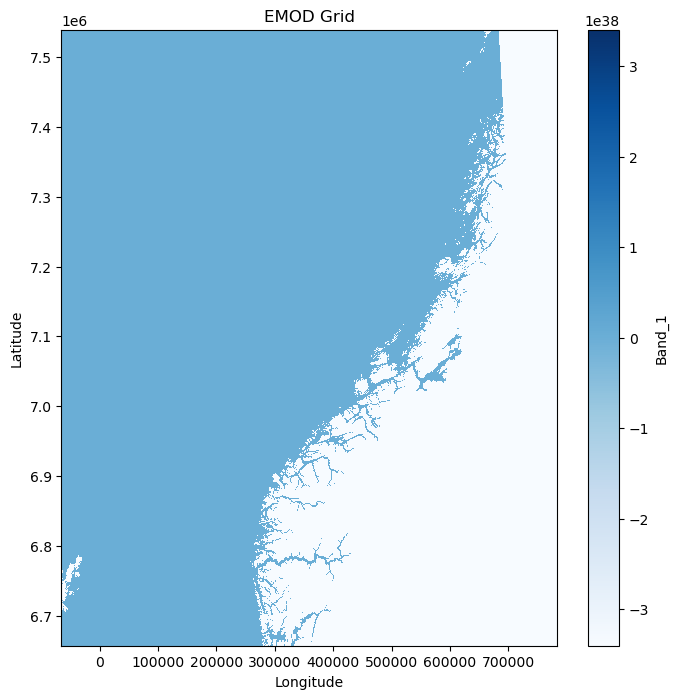

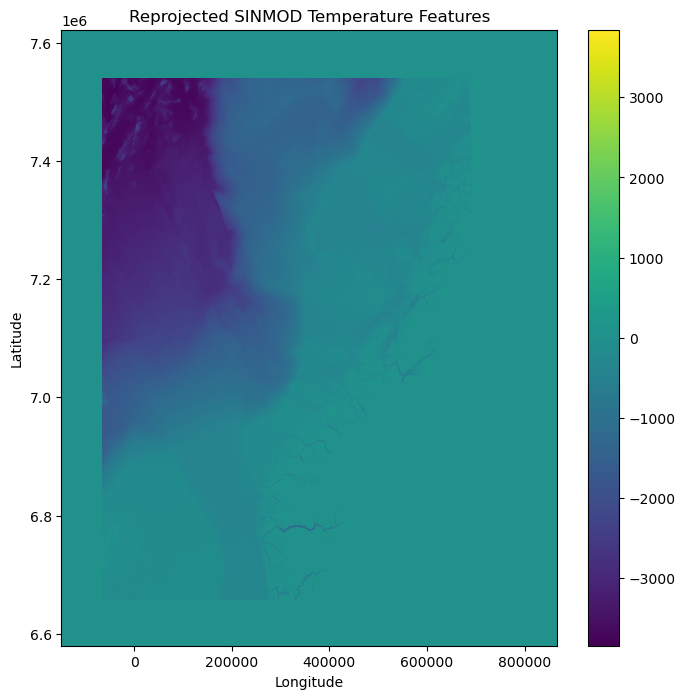

In [18]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import rasterio

aspect = rioxarray.open_rasterio('raw_data/EMOD-tifs/aspect_cos.tif')
bathymetry = rioxarray.open_rasterio('raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif')

# Plotting the EMOD grid
fig, ax = plt.subplots(figsize=(8, 8))
aspect.plot(ax=ax, cmap='Blues')
ax.set_title('EMOD Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plotting the reprojected SINMOD data (bottom_temperature, for example)
fig, ax = plt.subplots(figsize=(8, 8))
bathymetry.plot(ax=ax, cmap='viridis')
ax.set_title('Reprojected SINMOD Temperature Features')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# NOW REPEAT FOR EACH OF THE EMOD TIFFS
# Create a dataset to store all the clipped tif files
EMOD_features = xr.Dataset()

for file in tif_files:
    SINMOD_temp, file_tif = align_SINMOD_and_bathymetry(SINMOD_features, file)
    
    # Add the clipped tif as a new variable in the dataset
    var_name = file.split("/")[-1].split(".")[0] + "_clipped"
    EMOD_features[var_name] = file_tif

    file_tif.to_netcdf(f'processed_data/features/{var_name}.nc')

EMOD_features = EMOD_features.reset_coords(drop=True)
EMOD_features.to_netcdf('processed_data/features/EMOD_features.nc')

(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)


In [ ]:
# Saving the reprojected data

output_file = 'processed_data/features/ready-for-training/SINMOD_bottom_features_reprojected.nc'

SINMOD_features_reprojected.to_netcdf(output_file)